<h1>Navigation<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#REAL-DATA" data-toc-modified-id="REAL-DATA-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>REAL DATA</a></span><ul class="toc-item"><li><span><a href="#Prices---10" data-toc-modified-id="Prices---10-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Prices - 10</a></span></li><li><span><a href="#Changes---10" data-toc-modified-id="Changes---10-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Changes - 10</a></span></li><li><span><a href="#Prices---30" data-toc-modified-id="Prices---30-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Prices - 30</a></span></li><li><span><a href="#Changes---30" data-toc-modified-id="Changes---30-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Changes - 30</a></span></li><li><span><a href="#Prices---50" data-toc-modified-id="Prices---50-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Prices - 50</a></span></li><li><span><a href="#Changes---50" data-toc-modified-id="Changes---50-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Changes - 50</a></span></li><li><span><a href="#Prices---70" data-toc-modified-id="Prices---70-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Prices - 70</a></span></li><li><span><a href="#Changes---70" data-toc-modified-id="Changes---70-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Changes - 70</a></span></li><li><span><a href="#Prices---100" data-toc-modified-id="Prices---100-1.9"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>Prices - 100</a></span></li><li><span><a href="#Changes---100" data-toc-modified-id="Changes---100-1.10"><span class="toc-item-num">1.10&nbsp;&nbsp;</span>Changes - 100</a></span></li><li><span><a href="#Prices---120" data-toc-modified-id="Prices---120-1.11"><span class="toc-item-num">1.11&nbsp;&nbsp;</span>Prices - 120</a></span></li><li><span><a href="#Changes---120" data-toc-modified-id="Changes---120-1.12"><span class="toc-item-num">1.12&nbsp;&nbsp;</span>Changes - 120</a></span></li></ul></li></ul></div>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi

# Fiddle with figure settings here:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

# A simple little 2D matrix plotter, excluding x and y labels.
def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

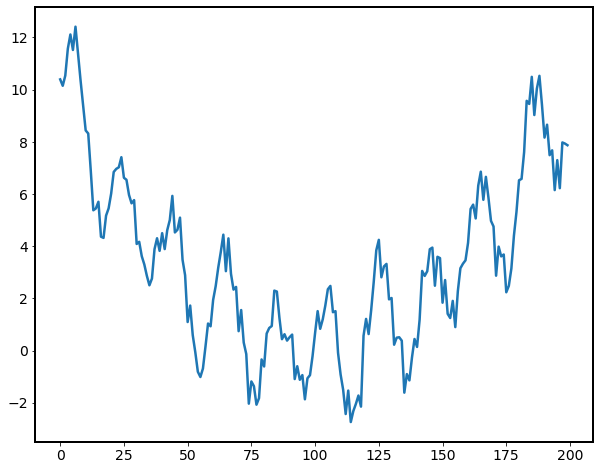

In [18]:
plt.plot(t, F, lw=2.5);

In [5]:
N = 200 # The number of time 'moments' in our toy series
t = np.arange(0,N)
trend = 0.001 * (t - 100)**2
p1, p2 = 20, 30
periodic1 = 2 * np.sin(2*pi*t/p1)
periodic2 = 0.75 * np.sin(2*pi*t/p2)

np.random.seed(123) # So we generate the same noisy time series every time.
noise = 2 * (np.random.rand(N) - 0.5)
F = trend + periodic1 + periodic2 + noise

In [7]:
class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)
        

In [8]:
F_SSA_40 = SSA(F, 40)

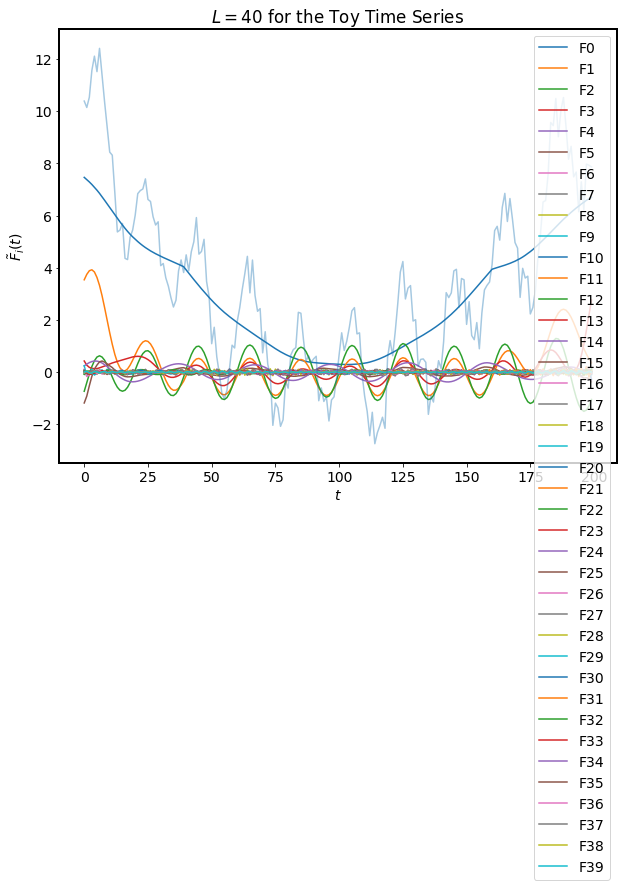

In [10]:
F_SSA_40.components_to_df().plot()
F_SSA_40.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=40$ for the Toy Time Series");

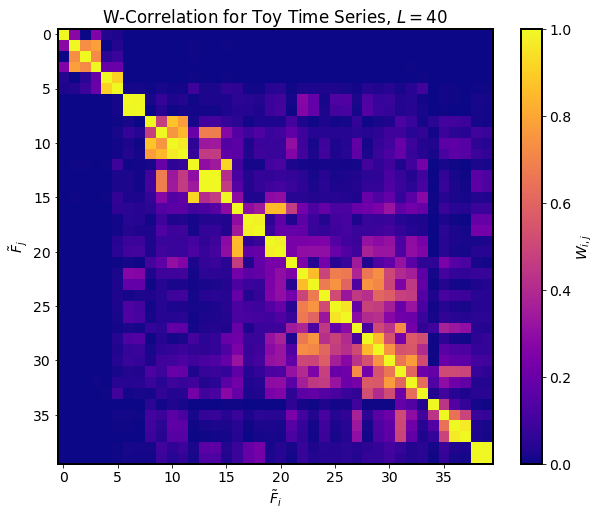

In [13]:
F_SSA_40.plot_wcorr()
plt.title("W-Correlation for Toy Time Series, $L=40$");

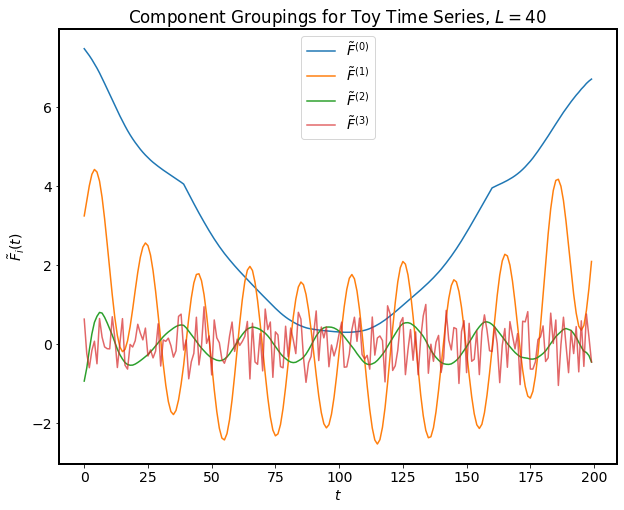

In [15]:
F_SSA_40.reconstruct(0).plot()
F_SSA_40.reconstruct([1,2,3]).plot()
F_SSA_40.reconstruct([4,5]).plot()
F_SSA_40.reconstruct(slice(6,40)).plot(alpha=0.7)
plt.title("Component Groupings for Toy Time Series, $L=40$")
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.legend([r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(4)]);

# REAL DATA

In [114]:
real_df = pd.read_csv('Python/Курсовая/USD_RUB.csv')
real_df = real_df[['Дата', 'Цена', 'Изм. %']]
real_df = real_df.set_index('Дата')
real_df.index = pd.to_datetime(real_df.index)
price = real_df['Цена']
changes = real_df['Изм. %']
for i in range(len(price.values)):
    price.values[i] = price.values[i].replace(',', '.')
for i in range(len(changes.values)):
    changes.values[i] = changes.values[i].replace(',', '.')
    changes.values[i] = changes.values[i].replace('%', '')
    
price = price.astype(np.float)
changes = changes.astype(np.float)
    
price = price.sort_index()
changes = changes.sort_index()

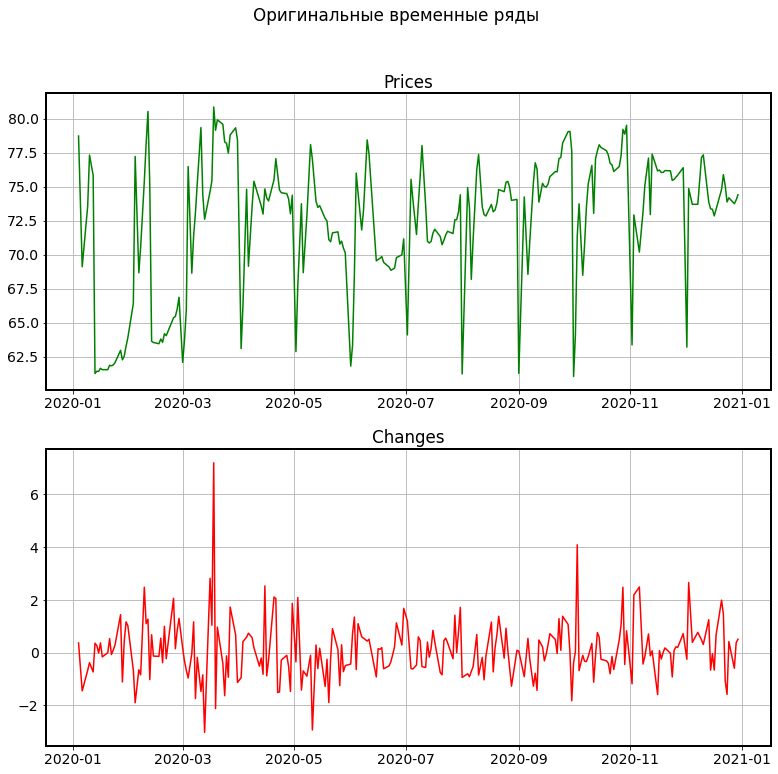

In [115]:
fig, (sub_1, sub_2) = plt.subplots(2, 1, figsize=(13, 12))
fig.suptitle('Оригинальные временные ряды')
plt.subplots_adjust(wspace=0.05)

sub_1.plot(price.index, price.values, color='g')
sub_1.set_title('Prices')

sub_2.plot(changes.index, changes.values, color='r')
sub_2.set_title('Changes')

sub_1.grid()
sub_2.grid()

plt.show()

## Prices - 10

In [173]:
prices_SSA_10 = SSA(price.values, 10)

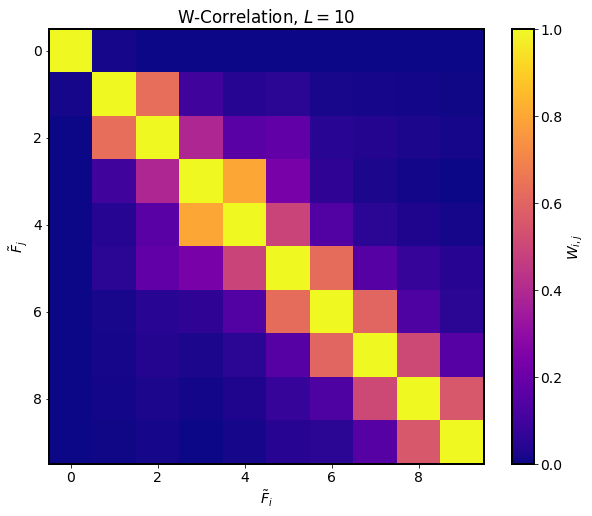

In [174]:
prices_SSA_10.plot_wcorr()
plt.title("W-Correlation, $L=10$");

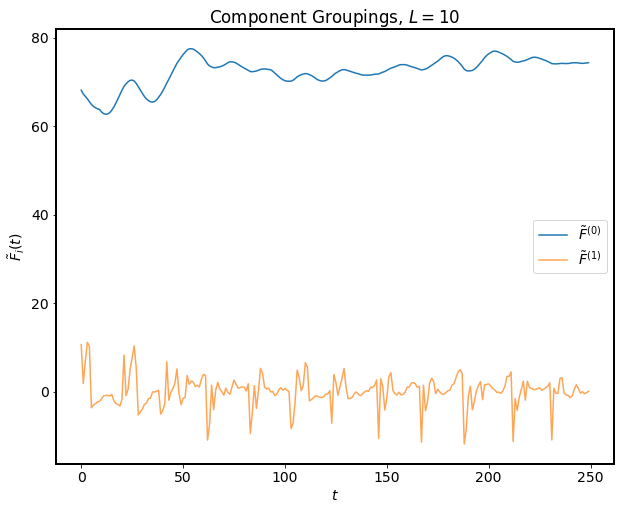

In [179]:
prices_SSA_10.reconstruct(0).plot()
prices_SSA_10.reconstruct(slice(1,10)).plot(alpha=0.7)
plt.title("Component Groupings, $L=10$")
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.legend([r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(7)]);

## Changes - 10

In [180]:
changes_SSA_10 = SSA(changes.values, 10)

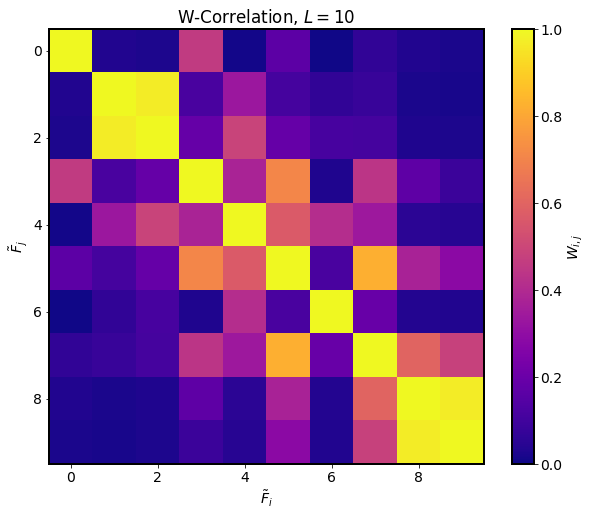

In [181]:
changes_SSA_10.plot_wcorr()
plt.title("W-Correlation, $L=10$");

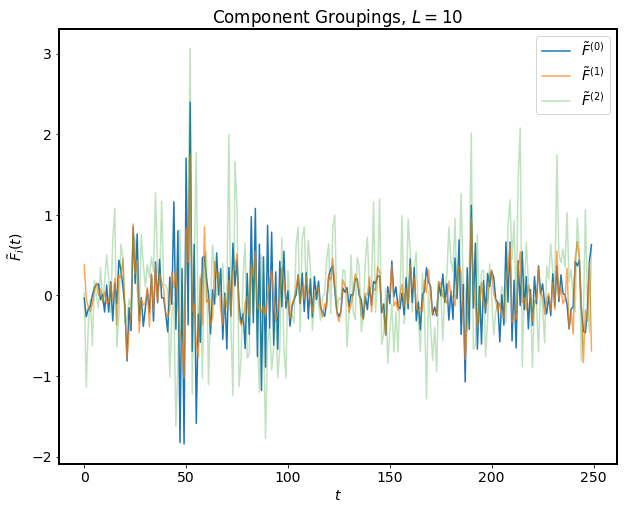

In [182]:
changes_SSA_10.reconstruct([0, 1]).plot()
changes_SSA_10.reconstruct([2, 3]).plot(alpha=0.7)
changes_SSA_10.reconstruct(slice(4,10)).plot(alpha=0.3)
plt.title("Component Groupings, $L=10$")
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.legend([r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(7)]);

## Prices - 30

In [183]:
prices_SSA_30 = SSA(price.values, 30)

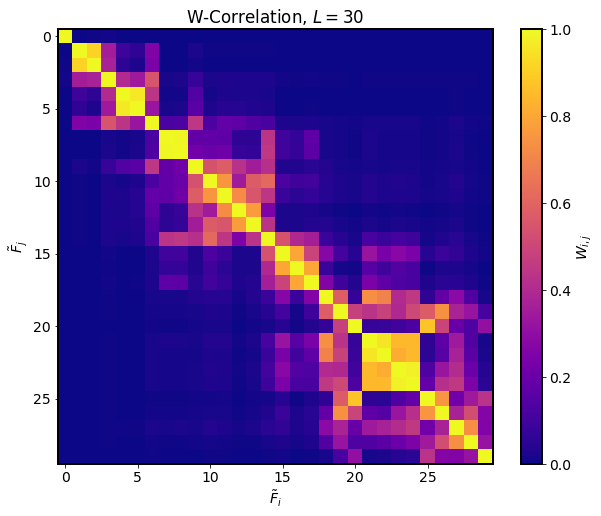

In [184]:
prices_SSA_30.plot_wcorr()
plt.title("W-Correlation, $L=30$");

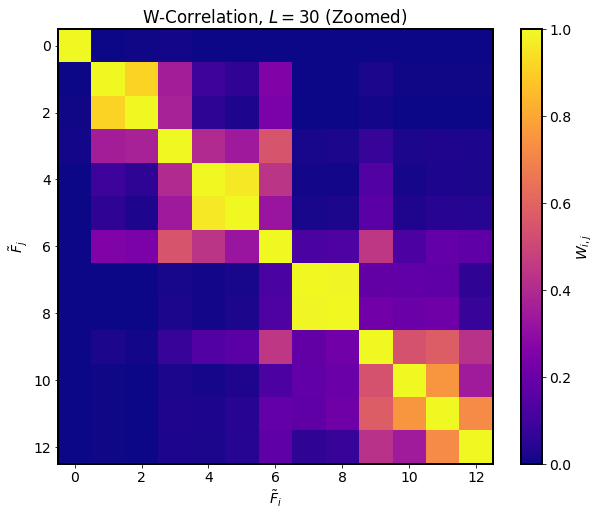

In [185]:
prices_SSA_30.plot_wcorr(max=12)
plt.title("W-Correlation, $L=30$ (Zoomed)");

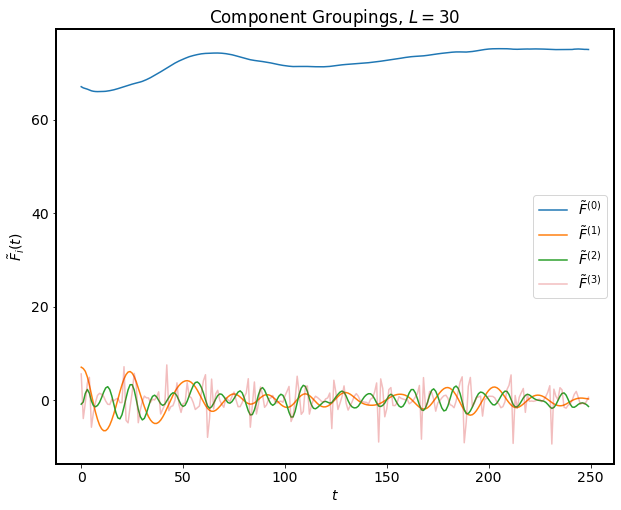

In [208]:
prices_SSA_30.reconstruct(0).plot()
prices_SSA_30.reconstruct([1, 2]).plot()
prices_SSA_30.reconstruct([3, 4, 5, 6]).plot()
prices_SSA_30.reconstruct(slice(7,70)).plot(alpha=0.3)
plt.title("Component Groupings, $L=30$")
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.legend([r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(7)]);

## Changes - 30

In [187]:
changes_SSA_30 = SSA(changes.values, 30)

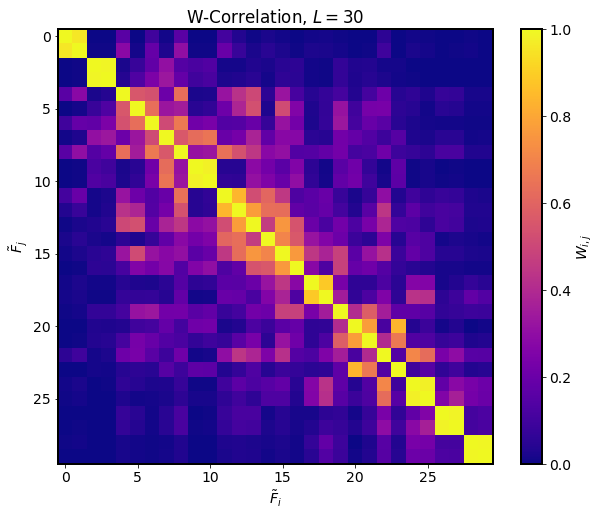

In [188]:
changes_SSA_30.plot_wcorr()
plt.title("W-Correlation, $L=30$");

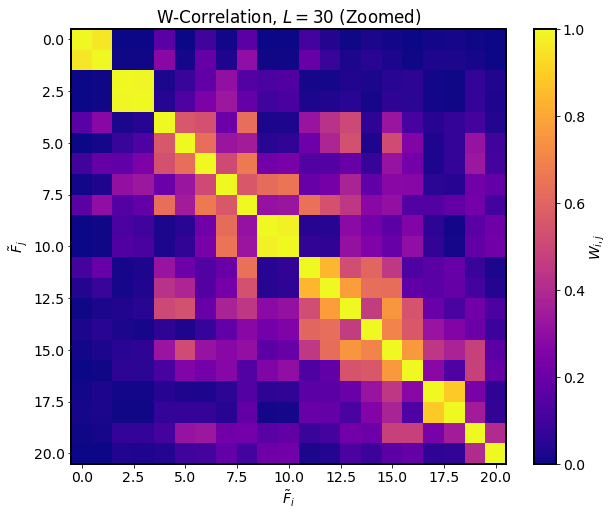

In [189]:
changes_SSA_30.plot_wcorr(max=20)
plt.title("W-Correlation, $L=30$ (Zoomed)");

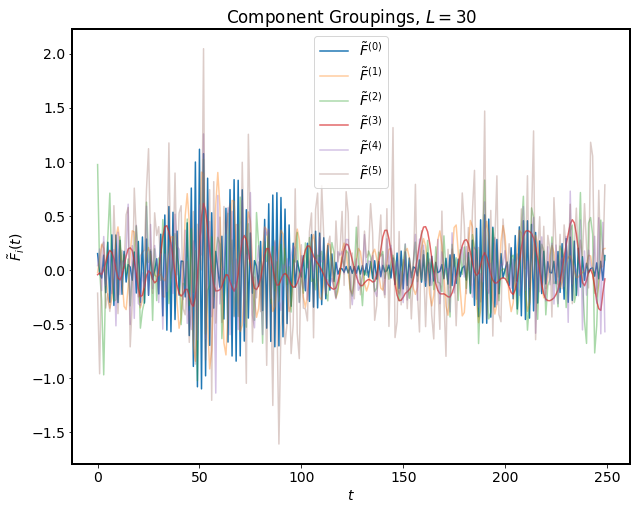

In [212]:
changes_SSA_30.reconstruct([0, 1]).plot()
changes_SSA_30.reconstruct([2, 3]).plot(alpha=0.4)
changes_SSA_30.reconstruct([4, 5, 6, 8]).plot(alpha=0.4)
changes_SSA_30.reconstruct([9, 10]).plot(alpha=0.7)
changes_SSA_30.reconstruct([11, 12, 13, 14, 15]).plot(alpha=0.4)
changes_SSA_30.reconstruct(slice(16,70)).plot(alpha=0.3)
plt.title("Component Groupings, $L=30$")
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.legend([r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(7)]);

## Prices - 50

In [191]:
prices_SSA_50 = SSA(price.values, 50)

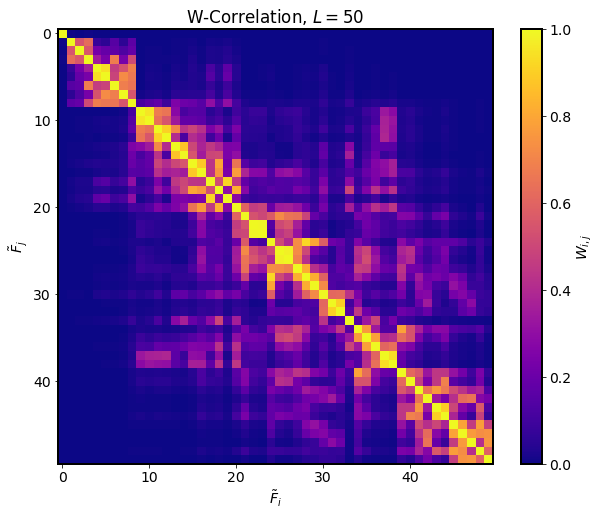

In [192]:
prices_SSA_50.plot_wcorr()
plt.title("W-Correlation, $L=50$");

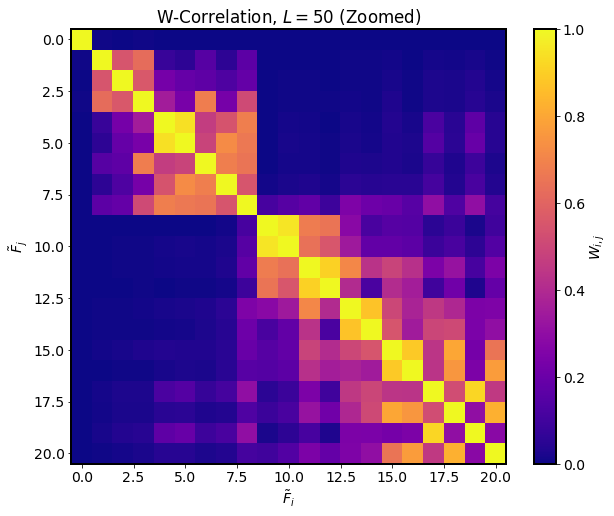

In [194]:
prices_SSA_50.plot_wcorr(max=20)
plt.title("W-Correlation, $L=50$ (Zoomed)");

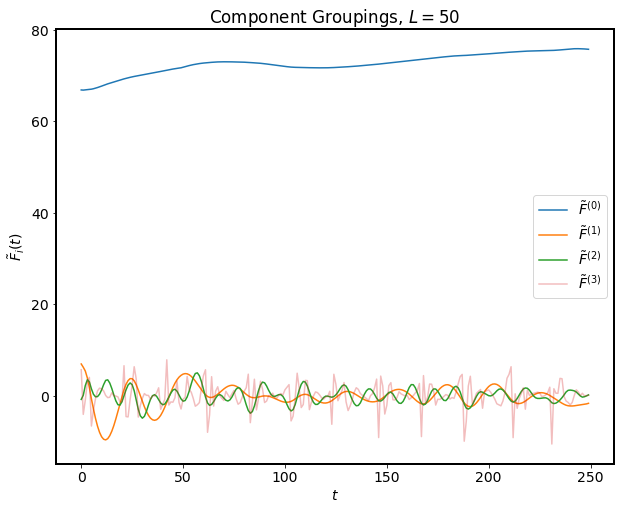

In [213]:
prices_SSA_50.reconstruct(0).plot()
prices_SSA_50.reconstruct([1, 2, 3]).plot()
prices_SSA_50.reconstruct([4, 5, 6, 7, 8]).plot()
prices_SSA_50.reconstruct(slice(9,70)).plot(alpha=0.3)
plt.title("Component Groupings, $L=50$")
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.legend([r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(7)]);

## Changes - 50

In [196]:
changes_SSA_50 = SSA(changes.values, 50)

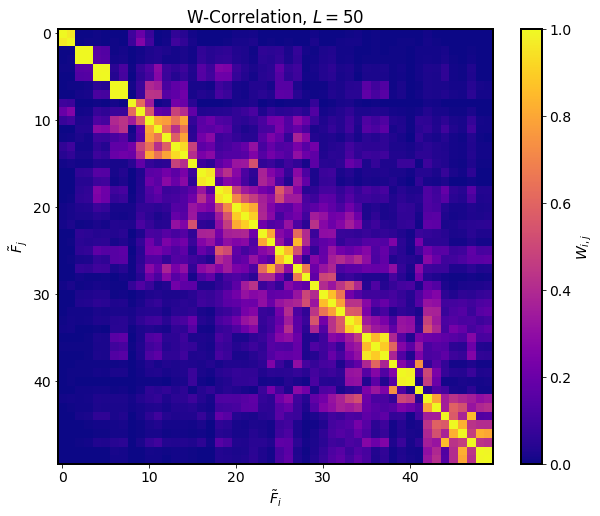

In [197]:
changes_SSA_50.plot_wcorr()
plt.title("W-Correlation, $L=50$");

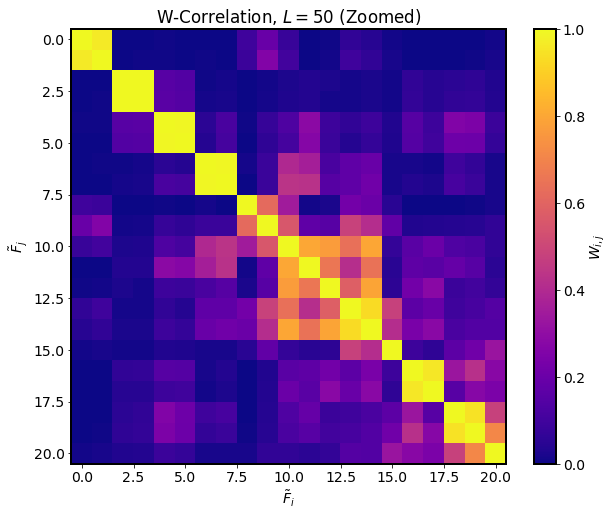

In [198]:
changes_SSA_50.plot_wcorr(max=20)
plt.title("W-Correlation, $L=50$ (Zoomed)");

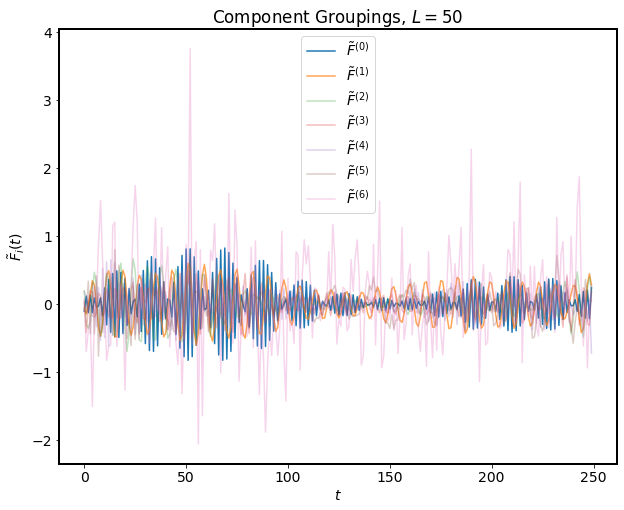

In [220]:
changes_SSA_50.reconstruct([0, 1]).plot()
changes_SSA_50.reconstruct([2, 3]).plot(alpha=0.7)
changes_SSA_50.reconstruct([4, 5]).plot(alpha=0.3)
changes_SSA_50.reconstruct([6, 7]).plot(alpha=0.3)
changes_SSA_50.reconstruct([8, 9, 10]).plot(alpha=0.3)
changes_SSA_50.reconstruct([11, 12, 13, 14]).plot(alpha=0.3)
changes_SSA_50.reconstruct(slice(15,70)).plot(alpha=0.3)
plt.title("Component Groupings, $L=50$")
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.legend([r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(7)]);

## Prices - 70

In [119]:
prices_SSA_70 = SSA(price.values, 70)

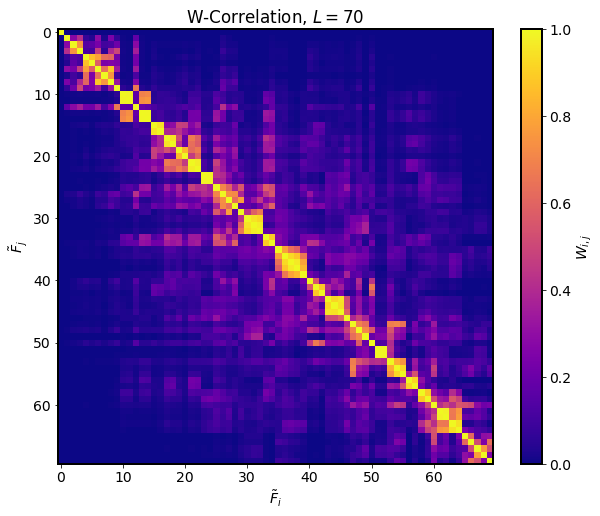

In [129]:
prices_SSA_70.plot_wcorr()
plt.title("W-Correlation, $L=70$");

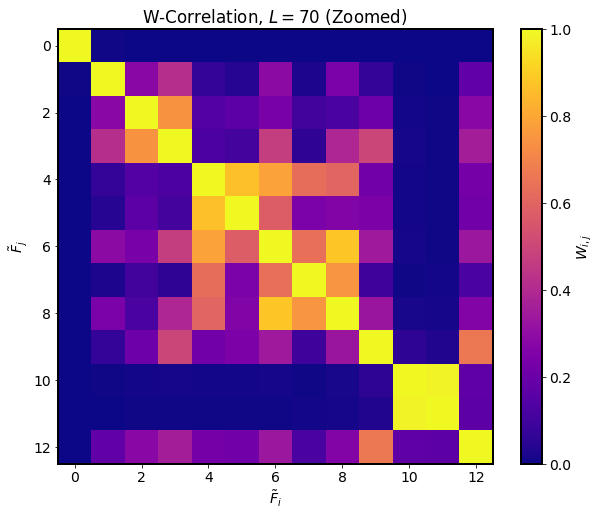

In [127]:
prices_SSA_70.plot_wcorr(max=12)
plt.title("W-Correlation, $L=70$ (Zoomed)");

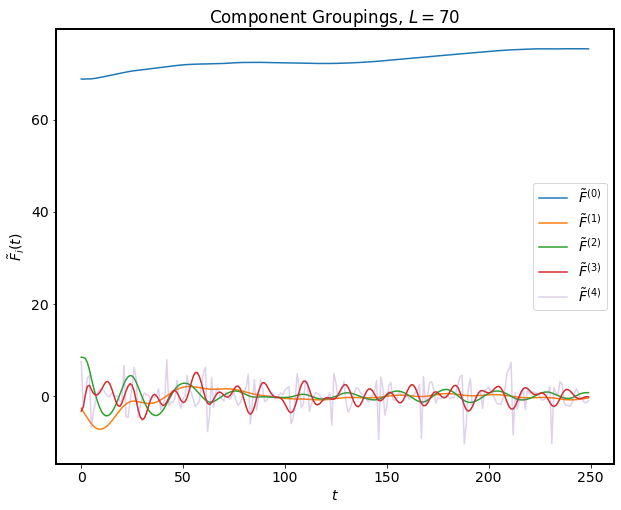

In [214]:
prices_SSA_70.reconstruct(0).plot()
prices_SSA_70.reconstruct(1).plot()
prices_SSA_70.reconstruct([2, 3]).plot()
prices_SSA_70.reconstruct([4, 5, 6, 7, 8, 9]).plot()
prices_SSA_70.reconstruct(slice(10,70)).plot(alpha=0.3)
plt.title("Component Groupings, $L=70$")
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.legend([r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(7)]);

## Changes - 70

In [140]:
changes_SSA_70 = SSA(changes.values, 70)

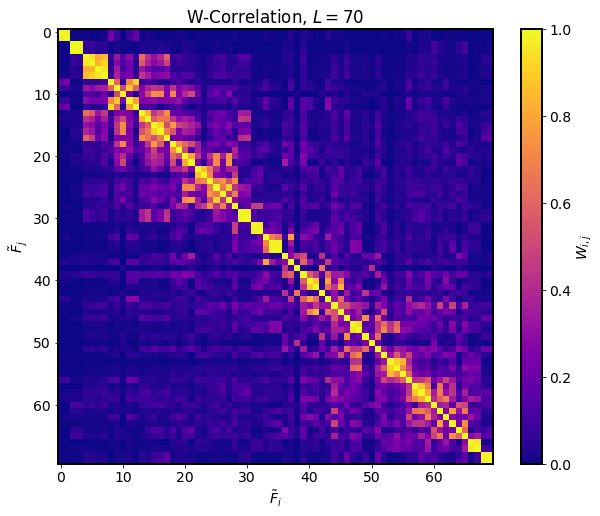

In [141]:
changes_SSA_70.plot_wcorr()
plt.title("W-Correlation, $L=70$");

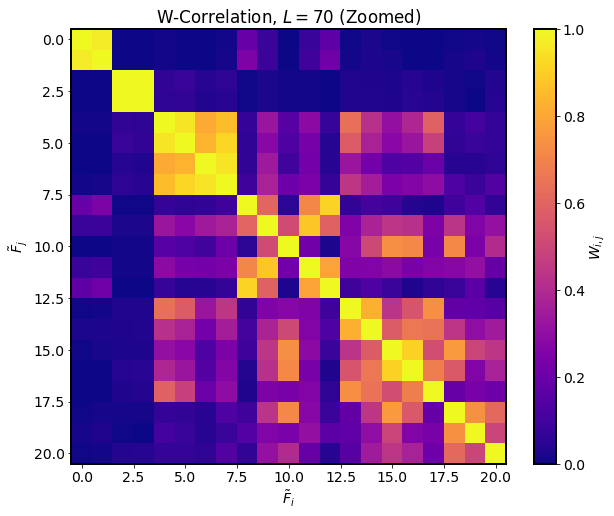

In [147]:
changes_SSA_70.plot_wcorr(max=20)
plt.title("W-Correlation, $L=70$ (Zoomed)");

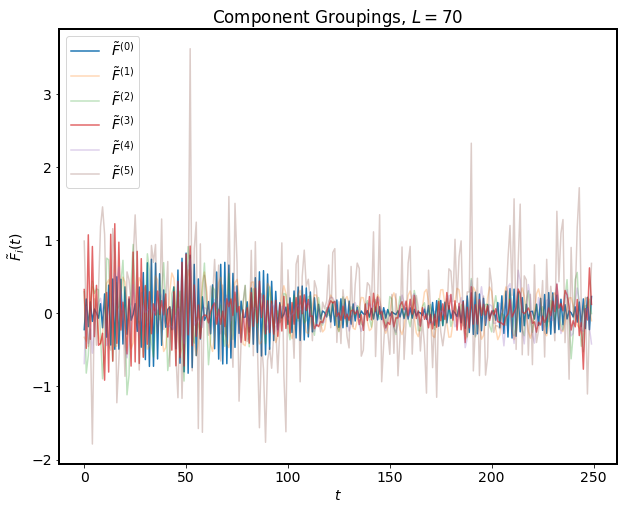

In [221]:
changes_SSA_70.reconstruct([0, 1]).plot()
changes_SSA_70.reconstruct([2, 3]).plot(alpha=0.3)
changes_SSA_70.reconstruct([4, 5, 6, 7]).plot(alpha=0.3)
changes_SSA_70.reconstruct([8, 9, 10, 11, 12]).plot(alpha=0.7)
changes_SSA_70.reconstruct([13, 14, 15, 16, 17]).plot(alpha=0.3)
changes_SSA_70.reconstruct(slice(18,70)).plot(alpha=0.3)
plt.title("Component Groupings, $L=70$")
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.legend([r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(7)]);

## Prices - 100

In [149]:
prices_SSA_100 = SSA(price.values, 100)

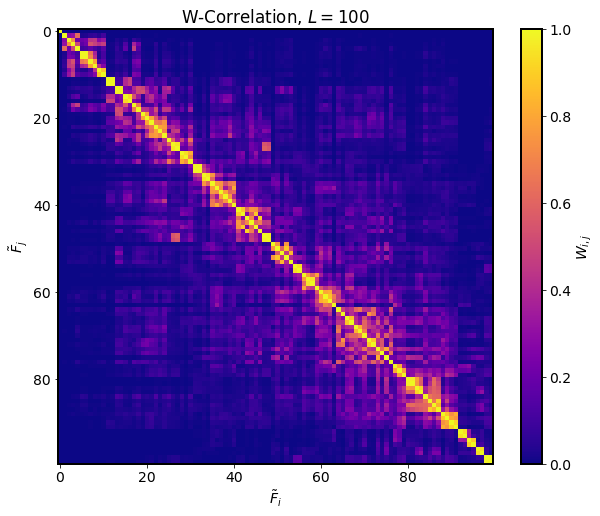

In [150]:
prices_SSA_100.plot_wcorr()
plt.title("W-Correlation, $L=100$");

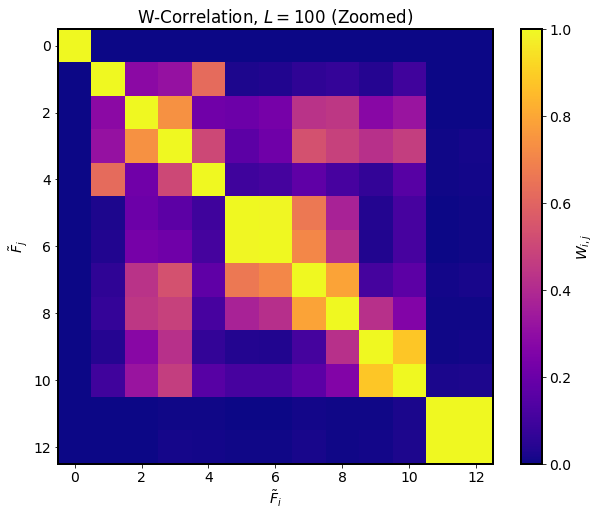

In [151]:
prices_SSA_100.plot_wcorr(max=12)
plt.title("W-Correlation, $L=100$ (Zoomed)");

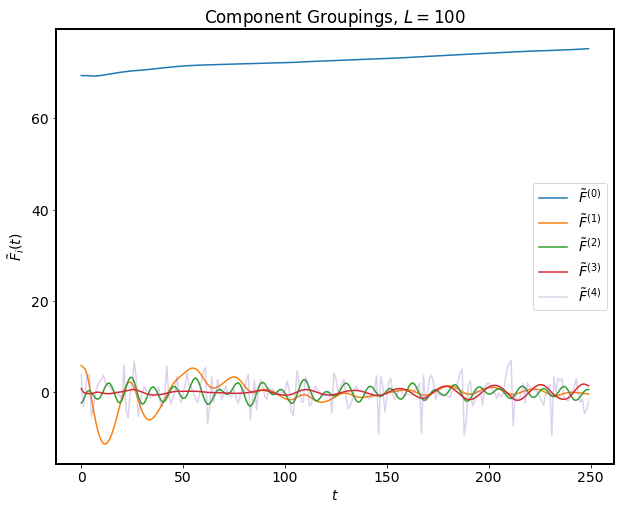

In [218]:
prices_SSA_100.reconstruct(0).plot()

prices_SSA_100.reconstruct([1, 2, 3, 4]).plot()
prices_SSA_100.reconstruct([5, 6, 7, 8]).plot()
prices_SSA_100.reconstruct([9, 10]).plot()
prices_SSA_100.reconstruct(slice(11,70)).plot(alpha=0.3)
plt.title("Component Groupings, $L=100$")
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.legend([r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(7)]);

## Changes - 100

In [153]:
changes_SSA_100 = SSA(changes.values, 100)

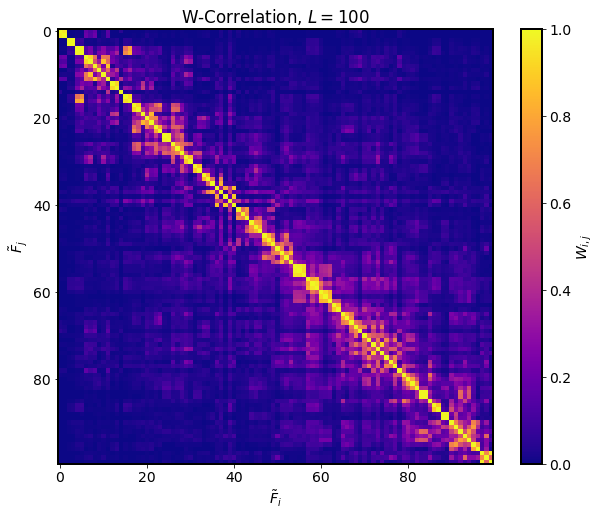

In [154]:
changes_SSA_100.plot_wcorr()
plt.title("W-Correlation, $L=100$");

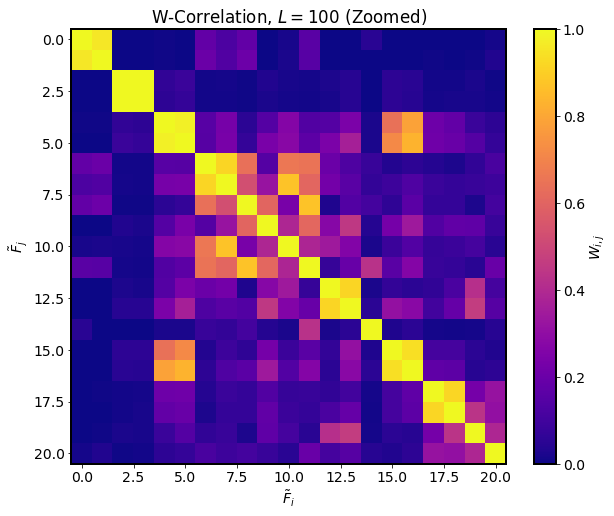

In [155]:
changes_SSA_100.plot_wcorr(max=20)
plt.title("W-Correlation, $L=100$ (Zoomed)");

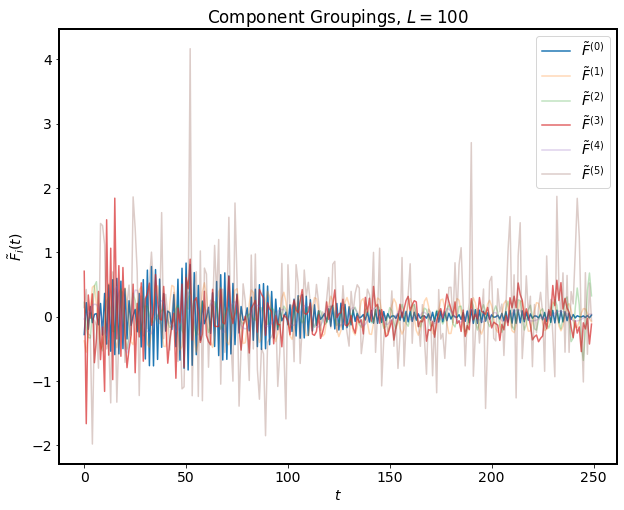

In [222]:
changes_SSA_100.reconstruct([0, 1]).plot()
changes_SSA_100.reconstruct([2, 3]).plot(alpha=0.3)
changes_SSA_100.reconstruct([4, 5]).plot(alpha=0.3)
changes_SSA_100.reconstruct([6, 7, 8, 9, 10, 11]).plot(alpha=0.7)
changes_SSA_100.reconstruct([12, 13]).plot(alpha=0.3)
changes_SSA_100.reconstruct(slice(14,70)).plot(alpha=0.3)
plt.title("Component Groupings, $L=100$")
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.legend([r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(7)]);

## Prices - 120

In [162]:
prices_SSA_120 = SSA(price.values, 120)

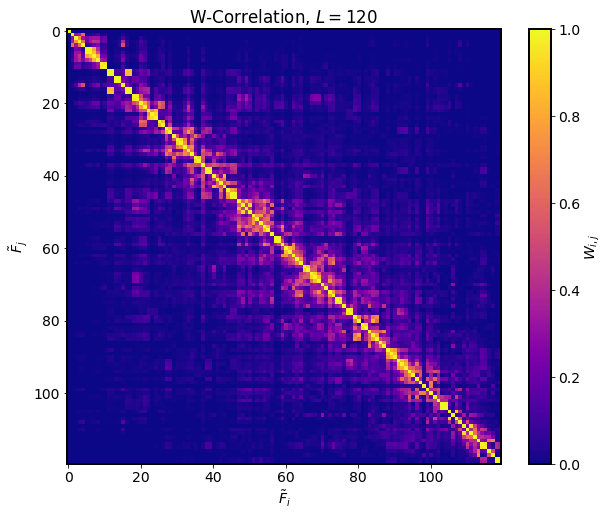

In [163]:
prices_SSA_120.plot_wcorr()
plt.title("W-Correlation, $L=120$");

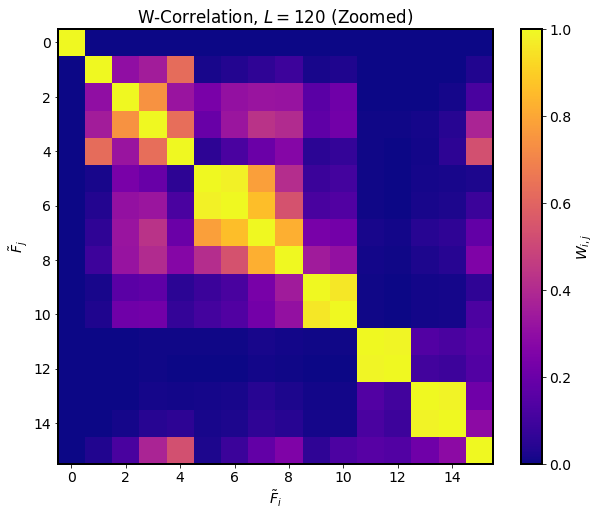

In [165]:
prices_SSA_120.plot_wcorr(max=15)
plt.title("W-Correlation, $L=120$ (Zoomed)");

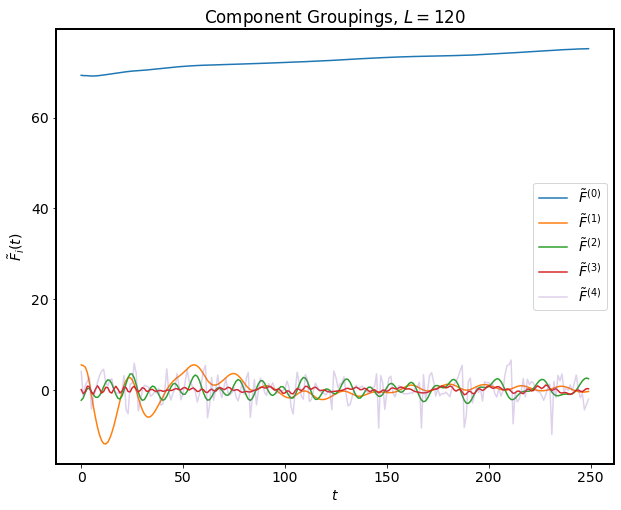

In [217]:
prices_SSA_120.reconstruct(0).plot()
prices_SSA_120.reconstruct([1, 2, 3, 4]).plot()
prices_SSA_120.reconstruct([5, 6, 7, 8, 9]).plot()
prices_SSA_120.reconstruct([10, 11]).plot()
prices_SSA_120.reconstruct(slice(12,70)).plot(alpha=0.3)
plt.title("Component Groupings, $L=120$")
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.legend([r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(7)]);

## Changes - 120

In [168]:
changes_SSA_120 = SSA(changes.values, 120)

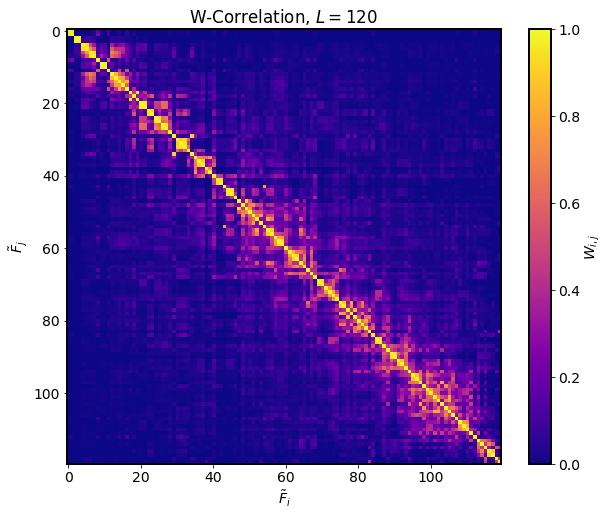

In [169]:
changes_SSA_120.plot_wcorr()
plt.title("W-Correlation, $L=120$");

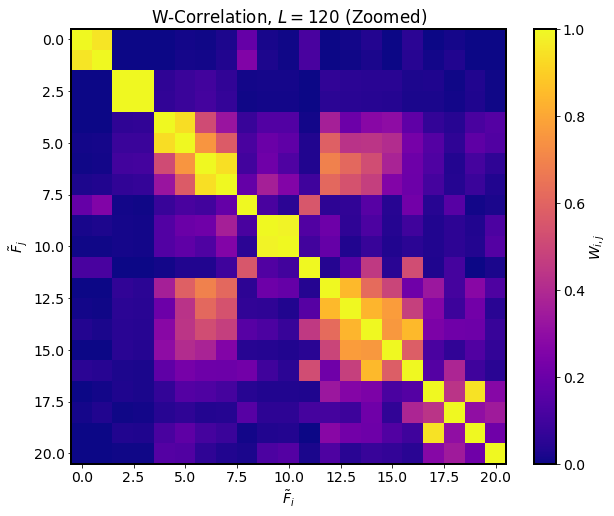

In [170]:
changes_SSA_120.plot_wcorr(max=20)
plt.title("W-Correlation, $L=120$ (Zoomed)");

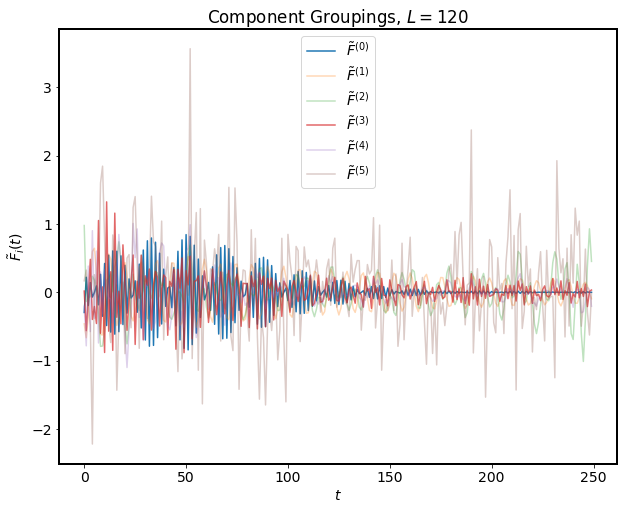

In [223]:
changes_SSA_120.reconstruct([0, 1]).plot()
changes_SSA_120.reconstruct([2, 3]).plot(alpha=0.3)
changes_SSA_120.reconstruct([4, 5, 6, 7]).plot(alpha=0.3)
changes_SSA_120.reconstruct([8, 9, 10, 11]).plot(alpha=0.7)
changes_SSA_120.reconstruct([12, 13, 14, 15, 16]).plot(alpha=0.3)
changes_SSA_120.reconstruct(slice(17,70)).plot(alpha=0.3)
plt.title("Component Groupings, $L=120$")
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.legend([r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(7)]);